<IMG SRC="https://avatars2.githubusercontent.com/u/31697400?s=400&u=a5a6fc31ec93c07853dd53835936fd90c44f7483&v=4" WIDTH=125 ALIGN="right">


# Resampling 

Resampling data is a very common operation when building a Modflow model. Usually it is used to project data from one grid onto the other. There are many different ways to do this. This notebook shows some examples of resampling methods that are incorporated in the `nlmod` package. These methods rely heavily on resampling methods in other packages such as `scipy.interpolate` and `xarray`.

### Contents<a name="TOC"></a>
1. [Grid types](#gridtypes)
2. [Structured grid to fine structured grid](#2)
3. [Structured grid to locally refined grid](#3)
4. [Locally refined grid to structured grid](#4)
5. [Fill nan values](#5)

In [1]:
import nlmod
from nlmod.mdims import resample
import numpy as np
import xarray as xr

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

from scipy.interpolate import RectBivariateSpline
import logging

In [2]:
print(f'nlmod version: {nlmod.__version__}')

# toon informatie bij het aanroepen van functies
logging.basicConfig(level=logging.INFO)

nlmod version: 0.2.0


### [1. Grid types](#TOC)<a name="gridtypes"></a>

So far two different gridtypes are supported in `nlmod`:
- structured grids where the cellsize is fixed for all cells
- vertex grids where the cellsize differs locally. These grids are usually created using local grid refinement algorithms.

In this notebook we define a few xarray dataarray of structured and vertex grids. We use these grids in the next chapter to show the resampling functions in `nlmod`.

#### structured grid 1

This structured grid has random numbers between 0 and 9. Has 10 x 10 cells.

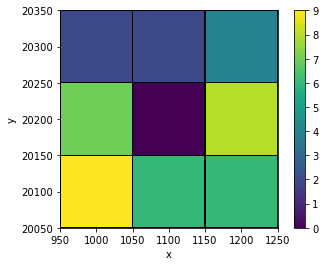

In [3]:
# structured grid 2d
x = np.arange(1000, 1300, 100)
y = np.arange(20300, 20000, -100)
data_2d = np.random.randint(0, 10, size=(len(y), len(x)))
struc2d = xr.DataArray(data_2d, dims=('y', 'x'),
                       coords={'x': x,
                               'y': y})
fig, ax = plt.subplots()
ax.set_aspect('equal')
qm = struc2d.plot(ax=ax, lw=0.1, edgecolor='k')


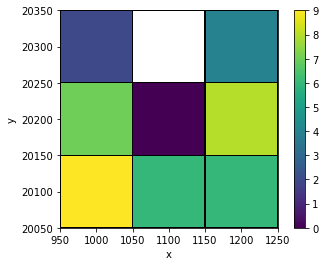

In [4]:
# structured grid 2d with nan value
struc2d_nan = struc2d.copy().astype(float)
struc2d_nan.values[0][1] = np.nan
fig, ax = plt.subplots()
ax.set_aspect('equal')
qm = struc2d_nan.plot(ax=ax, lw=0.1, edgecolor='k')


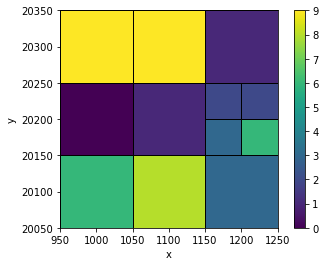

In [5]:
# vertex grid 1
dx = 100
dy = 100
x = np.arange(1000, 1300, dx)
y = np.arange(20300, 20000, -dy)
split_cell_no = 5

# create structured grid
xv, yv = np.meshgrid(x, y)
xyi = np.stack((np.ravel(xv), np.ravel(yv)), axis=-1)

# create vertices
vertices = np.ones((len(xyi), 4, 2))
for i, xy in enumerate(xyi):
    vertices[i] = np.array([[xy[0]-(dx/2), xy[1]+(dy/2)],
                            [xy[0]+(dx/2), xy[1]+(dy/2)],
                            [xy[0]+(dx/2), xy[1]-(dy/2)],
                            [xy[0]-(dx/2), xy[1]-(dy/2)]])

# remove refined cell from structured grid
split_cell_coord = xyi[split_cell_no]
xyi = np.delete(xyi, split_cell_no, 0)
vertices = np.delete(vertices, split_cell_no, 0)

# get cell centers of refined cell
xy_refined = np.array([[split_cell_coord[0]-(dx/4), split_cell_coord[1]+(dy/4)], 
                       [split_cell_coord[0]+(dx/4), split_cell_coord[1]+(dy/4)], 
                       [split_cell_coord[0]-(dx/4), split_cell_coord[1]-(dy/4)], 
                       [split_cell_coord[0]+(dx/4), split_cell_coord[1]-(dy/4)]])

# get vertices of refined cell
vert_refined = np.ones((len(xy_refined), 4, 2))
for i, xy in enumerate(xy_refined):
    vert_refined[i] = np.array([[xy[0]-(dx/4), xy[1]+(dy/4)],
                                [xy[0]+(dx/4), xy[1]+(dy/4)],
                                [xy[0]+(dx/4), xy[1]-(dy/4)],
                                [xy[0]-(dx/4), xy[1]-(dy/4)]])

# add refined cell to the grid and vertices
xyi = np.insert(xyi, split_cell_no, xy_refined, axis=0)
vertices = np.insert(vertices, split_cell_no, vert_refined, axis=0)

# get cellid
cid = np.arange(len(xyi))

# create values
values = np.random.randint(0, 10, size=len(cid))

# create vertextured dataarray
vertex1 = xr.DataArray(values, dims=('cid'),
                        coords={'cid': cid})
nlmod.visualise.plots.plot_vertex_array(vertex1, vertices, gridkwargs={'edgecolor': 'k'});

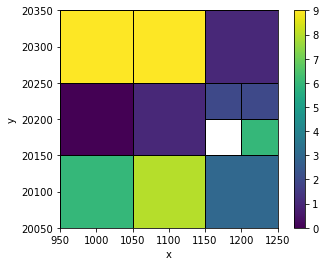

In [6]:
# vertextured grid 2 with nan
vertex1_nan = vertex1.copy().astype(float)
vertex1_nan.values[7] = np.nan

nlmod.visualise.plots.plot_vertex_array(vertex1_nan, vertices, gridkwargs={'edgecolor': 'k'},
                              vmin=vertex1_nan.min(), vmax=vertex1_nan.max());

## [2 Structured grid to fine structured grid](#TOC)<a name="2"></a>

In [7]:
# new grid dimensions
xmid = np.arange(950, 1300, 50)
ymid = np.arange(20350, 20000, -50)

### nearest

Text(0.5, 1.0, 'resampled grid')

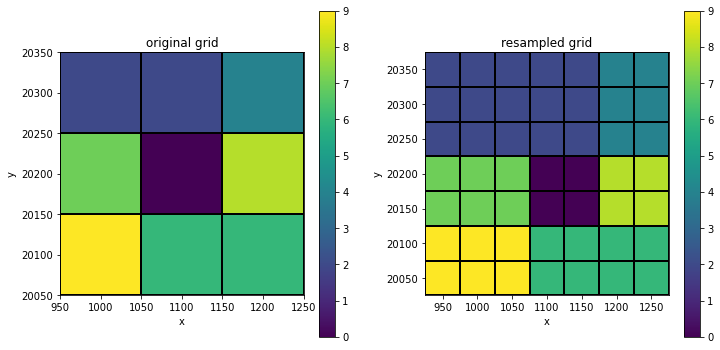

In [8]:
struc_out = resample.resample_dataarray2d_to_structured_grid(struc2d, xmid=xmid, ymid=ymid,
                                                             kind='nearest')
# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('original grid')
struc_out.plot(ax=axes[1], edgecolor='k')
axes[1].set_aspect('equal')
axes[1].set_title('resampled grid')

#### nearest with nan values

Text(0.5, 1.0, 'resampled grid')

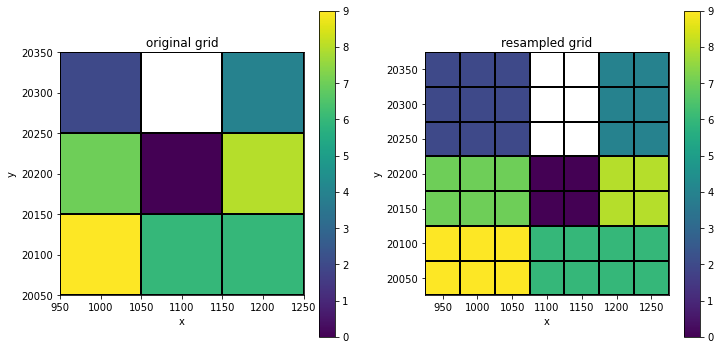

In [9]:
struc_out = resample.resample_dataarray2d_to_structured_grid(struc2d_nan, xmid=xmid, ymid=ymid,
                                                             kind='nearest')
# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d_nan.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('original grid')
struc_out.plot(ax=axes[1], edgecolor='k')
axes[1].set_aspect('equal')
axes[1].set_title('resampled grid')

### linear

Text(0.5, 1.0, 'resampled grid')

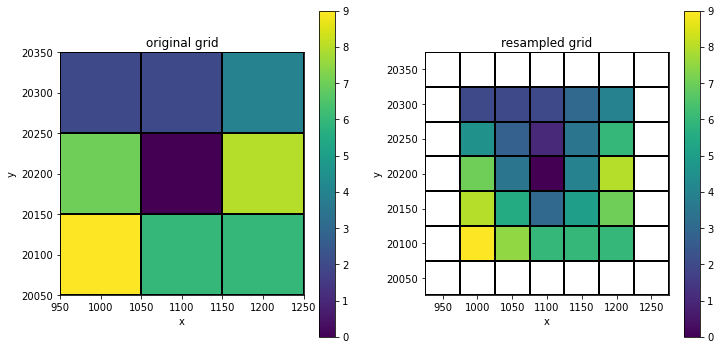

In [10]:
struc_out = resample.resample_dataarray2d_to_structured_grid(struc2d, xmid=xmid, ymid=ymid,
                                                             kind='linear', fill_value=np.nan)
# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('original grid')
struc_out.plot(ax=axes[1], edgecolor='k')
axes[1].set_aspect('equal')
axes[1].set_title('resampled grid')

Text(0.5, 1.0, 'resampled grid')

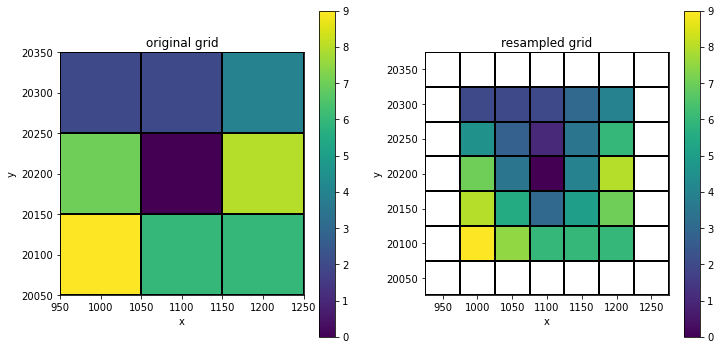

In [11]:
struc_out = resample.resample_dataarray2d_to_structured_grid(struc2d, xmid=xmid, ymid=ymid,
                                                             kind='linear', fill_value=np.nan)
# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('original grid')
struc_out.plot(ax=axes[1], edgecolor='k')
axes[1].set_aspect('equal')
axes[1].set_title('resampled grid')

### linear with nans in input

Text(0.5, 1.0, 'resampled grid')

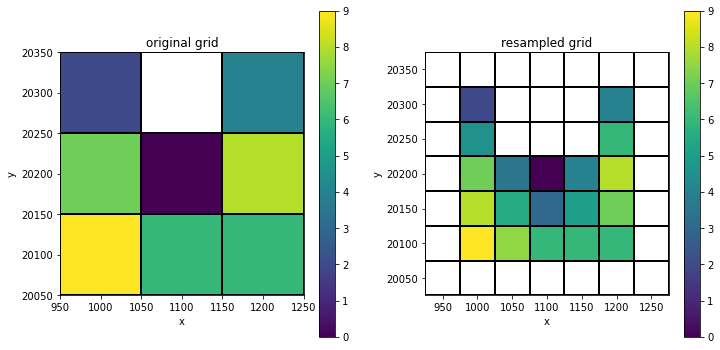

In [12]:
struc_out = resample.resample_dataarray2d_to_structured_grid(struc2d_nan, xmid=xmid, ymid=ymid,
                                                             kind='linear', fill_value=np.nan)
# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d_nan.plot(ax=axes[0], edgecolor='k', vmin=0)
axes[0].set_aspect('equal')
axes[0].set_title('original grid')
struc_out.plot(ax=axes[1], edgecolor='k', vmin=0)
axes[1].set_aspect('equal')
axes[1].set_title('resampled grid')

### Cubic

Text(0.5, 1.0, 'resampled grid')

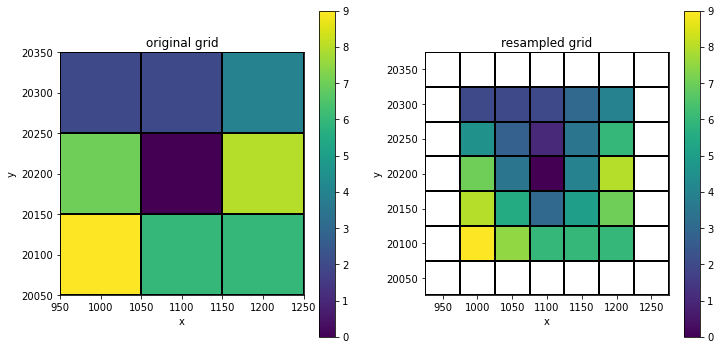

In [13]:
struc_out = resample.resample_dataarray2d_to_structured_grid(struc2d, xmid=xmid, ymid=ymid,
                                                           kind='cubic', fill_value=np.nan)

# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('original grid')
struc_out.plot(ax=axes[1], edgecolor='k')
axes[1].set_aspect('equal')
axes[1].set_title('resampled grid')

### Cubic with nans in input

Text(0.5, 1.0, 'resampled grid')

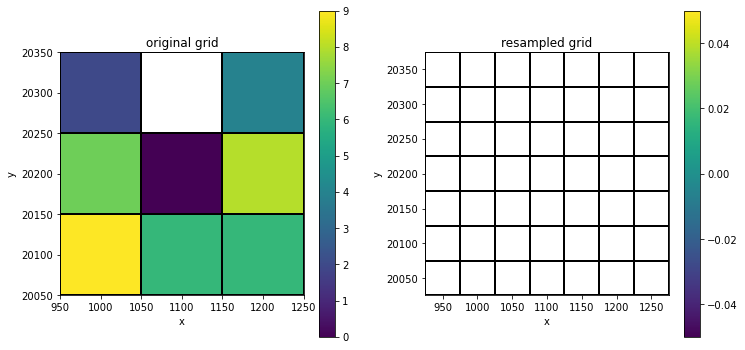

In [14]:
struc_out = resample.resample_dataarray2d_to_structured_grid(struc2d_nan, xmid=xmid, ymid=ymid,
                                                           kind='cubic')

# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d_nan.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('original grid')
struc_out.plot(ax=axes[1], edgecolor='k')
axes[1].set_aspect('equal')
axes[1].set_title('resampled grid')

### Rectangular Bivariate Spline (not yet included in nlmod)

Text(0.5, 1.0, 'resampled grid')

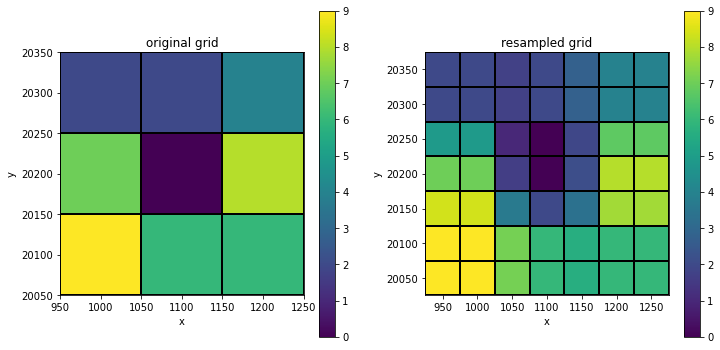

In [15]:
interp_spline = RectBivariateSpline(struc2d.x.values, struc2d.y.values[::-1], struc2d.values[::-1], 
                                    ky=min(3,len(struc2d.y)-1), 
                                    kx=min(3,len(struc2d.x)-1))
arr_out = interp_spline(xmid, ymid[::-1], grid=True)[::-1]
struc_out = xr.DataArray(arr_out, dims=('y', 'x'),
                         coords={'x': xmid,
                                 'y': ymid})

# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('original grid')
struc_out.plot(ax=axes[1], edgecolor='k', vmin=0)
axes[1].set_aspect('equal')
axes[1].set_title('resampled grid')

### Rectangular Bivariate Spline with nans (not yet included in nlmod)

Text(0.5, 1.0, 'resampled grid')

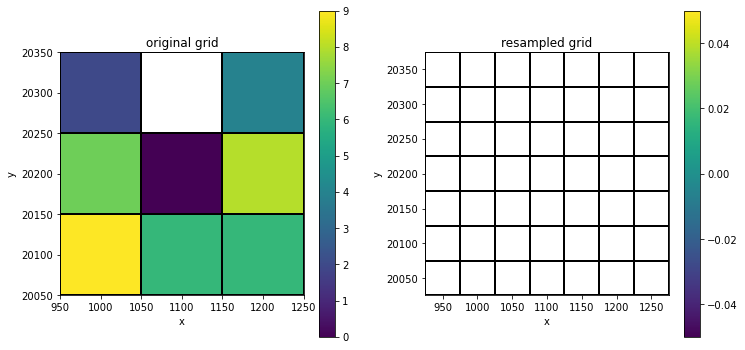

In [16]:
interp_spline = RectBivariateSpline(struc2d_nan.x.values, struc2d_nan.y.values[::-1], struc2d_nan.values[::-1], 
                                    ky=min(3,len(struc2d_nan.y)-1), 
                                    kx=min(3,len(struc2d_nan.x)-1))
interp_spline = RectBivariateSpline(struc2d_nan.x.values, struc2d_nan.y.values[::-1], struc2d_nan.values[::-1], 
                                    ky=min(3,len(struc2d_nan.y)-1), 
                                    kx=min(3,len(struc2d_nan.x)-1))
arr_out = interp_spline(xmid, ymid[::-1], grid=True)[::-1]
struc_out = xr.DataArray(arr_out, dims=('y', 'x'),
                         coords={'x': xmid,
                                 'y': ymid})

# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d_nan.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('original grid')
struc_out.plot(ax=axes[1], edgecolor='k')
axes[1].set_aspect('equal')
axes[1].set_title('resampled grid')

## [3. Structured grid to locally refined grid](#TOC)<a name="3"></a>



#### Nearest

In [17]:
res_vertex2d_n = resample.resample_dataarray2d_to_vertex_grid(struc2d, xyi=xyi, cid=cid)

Text(0.5, 1.0, 'locally refined grid')

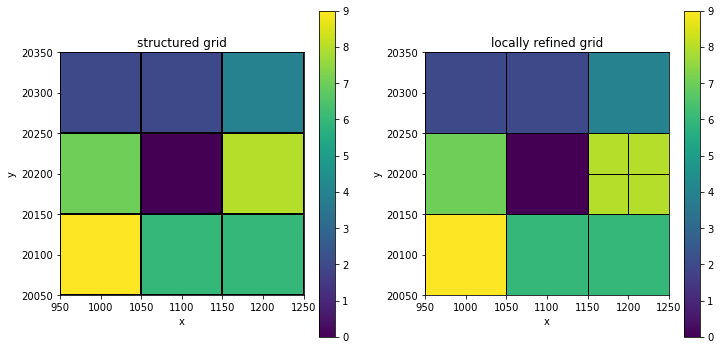

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('structured grid')
nlmod.visualise.plots.plot_vertex_array(res_vertex2d_n, vertices, ax=axes[1], gridkwargs={'edgecolor': 'k'})
axes[1].set_title('locally refined grid')

#### Linear

In [19]:
res_vertex2d_l = resample.resample_dataarray2d_to_vertex_grid(struc2d, xyi=xyi, cid=cid, method='linear')

Text(0.5, 1.0, 'locally refined grid')

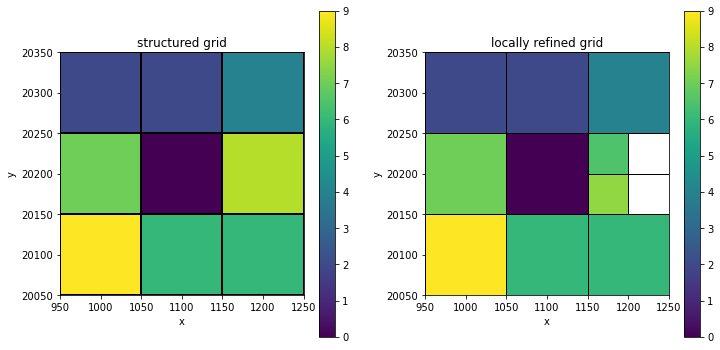

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('structured grid')
nlmod.visualise.plots.plot_vertex_array(res_vertex2d_l, vertices, ax=axes[1], gridkwargs={'edgecolor': 'k'}, vmin=struc2d.min(), vmax=struc2d.max())
axes[1].set_title('locally refined grid')

#### Cubic

In [21]:
res_vertex2d_c = resample.resample_dataarray2d_to_vertex_grid(struc2d, xyi=xyi, cid=cid, method='cubic')

Text(0.5, 1.0, 'locally refined grid')

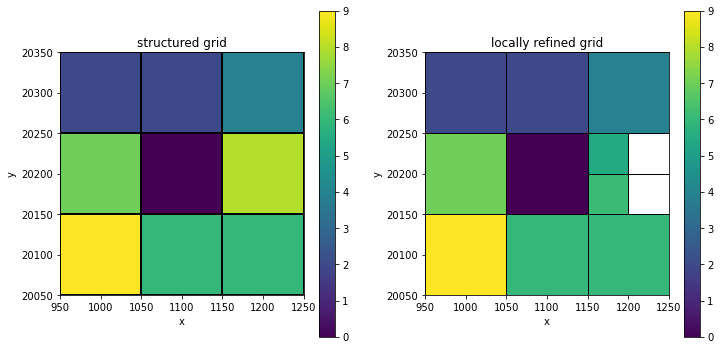

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('structured grid')
nlmod.visualise.plots.plot_vertex_array(res_vertex2d_c, vertices, ax=axes[1], gridkwargs={'edgecolor': 'k'}, vmin=struc2d.min(), vmax=struc2d.max())
axes[1].set_title('locally refined grid')

## [4. Locally refined grid to structured grid](#TOC)<a name="4"></a>



#### nearest

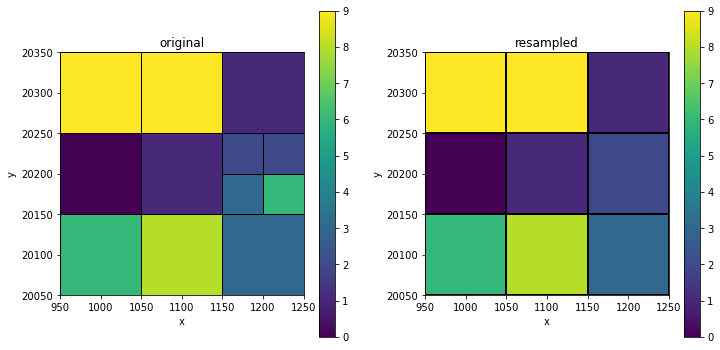

In [23]:
struc_out_n = resample.resample_vertex_2d_da_to_struc_2d_da(vertex1, xmid=xyi[:,0], ymid=xyi[:,1], cellsize=100,
                                                         method='nearest')

# plot
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
nlmod.visualise.plots.plot_vertex_array(vertex1, vertices, ax=axes[0], gridkwargs={'edgecolor': 'k'})
axes[0].set_title('original')
struc_out_n.plot(ax=axes[1], edgecolor='k')
axes[1].set_title('resampled')
axes[1].set_aspect('equal')

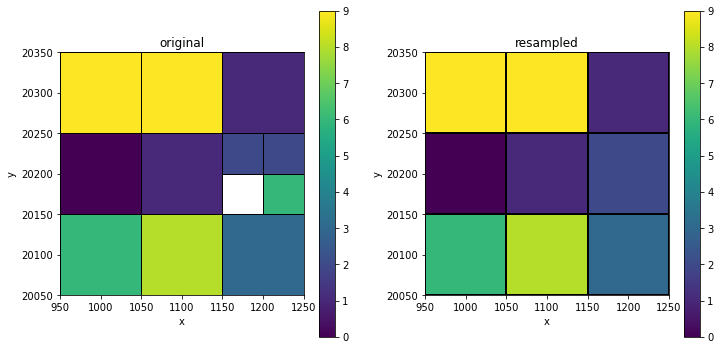

In [24]:
struc_out_nan_n = resample.resample_vertex_2d_da_to_struc_2d_da(vertex1_nan, xmid=xyi[:,0], ymid=xyi[:,1], cellsize=100,
                                                              method='nearest')

# plot
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
nlmod.visualise.plots.plot_vertex_array(vertex1_nan, vertices, ax=axes[0], gridkwargs={'edgecolor': 'k'},
                              vmin=vertex1_nan.min(), vmax=vertex1_nan.max())
axes[0].set_title('original')
struc_out_nan_n.plot(ax=axes[1], edgecolor='k')
axes[1].set_title('resampled')
axes[1].set_aspect('equal')

### linear

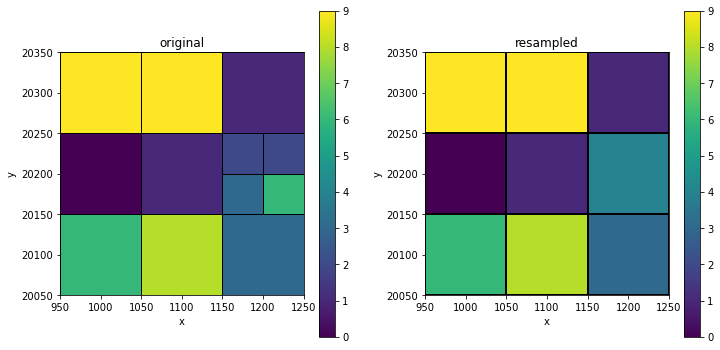

In [25]:
struc_out_l = resample.resample_vertex_2d_da_to_struc_2d_da(vertex1, xmid=xyi[:,0], ymid=xyi[:,1], cellsize=100,
                                                         method='linear')

# plot figure
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
nlmod.visualise.plots.plot_vertex_array(vertex1, vertices, ax=axes[0], gridkwargs={'edgecolor': 'k'})
axes[0].set_title('original')
struc_out_l.plot(ax=axes[1], edgecolor='k')
axes[1].set_title('resampled')
axes[1].set_aspect('equal')

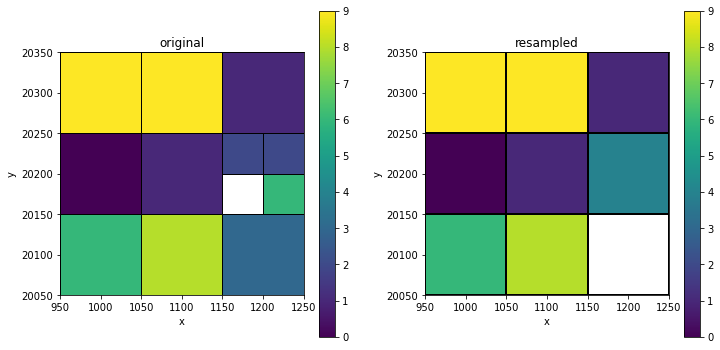

In [26]:
struc_out_l_nan = resample.resample_vertex_2d_da_to_struc_2d_da(vertex1_nan, xmid=xyi[:,0], ymid=xyi[:,1], cellsize=100,
                                                               method='linear')

# plot figure
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
nlmod.visualise.plots.plot_vertex_array(vertex1_nan, vertices, ax=axes[0], gridkwargs={'edgecolor': 'k'},
                              vmin=vertex1_nan.min(), vmax=vertex1_nan.max())
axes[0].set_title('original')
struc_out_l_nan.plot(ax=axes[1], edgecolor='k')
axes[1].set_title('resampled')
axes[1].set_aspect('equal')

### cubic

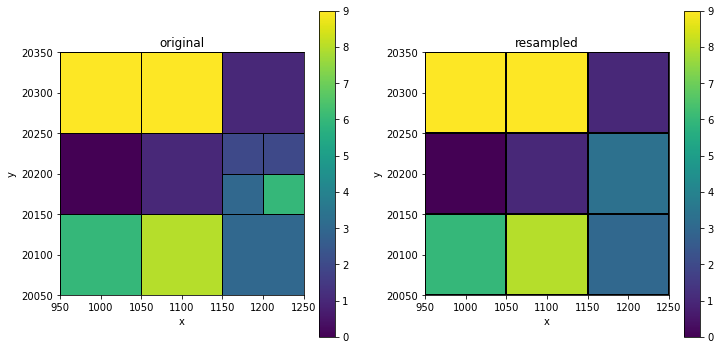

In [27]:
struc_out_c = resample.resample_vertex_2d_da_to_struc_2d_da(vertex1, xmid=xyi[:,0], ymid=xyi[:,1], cellsize=100,
                                                         method='cubic')

# plot figure
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
nlmod.visualise.plots.plot_vertex_array(vertex1, vertices, ax=axes[0], gridkwargs={'edgecolor': 'k'})
axes[0].set_title('original')
struc_out_c.plot(ax=axes[1], edgecolor='k')
axes[1].set_title('resampled')
axes[1].set_aspect('equal')

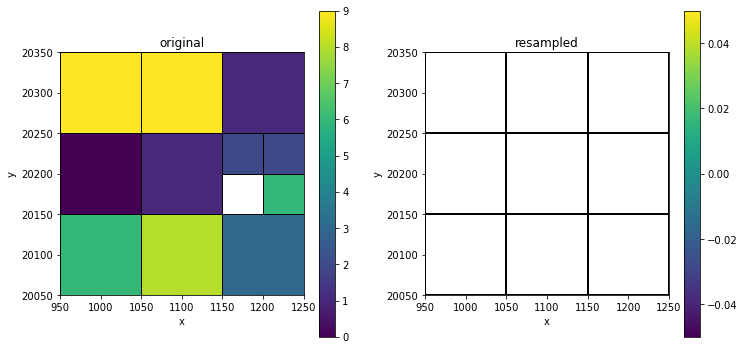

In [28]:
struc_out_c_nan = resample.resample_vertex_2d_da_to_struc_2d_da(vertex1_nan, xmid=xyi[:,0], ymid=xyi[:,1], cellsize=100,
                                                               method='cubic')

# plot figure
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
nlmod.visualise.plots.plot_vertex_array(vertex1_nan, vertices, ax=axes[0], gridkwargs={'edgecolor': 'k'},
                              vmin=vertex1_nan.min(), vmax=vertex1_nan.max())
axes[0].set_title('original')
struc_out_c_nan.plot(ax=axes[1], edgecolor='k')
axes[1].set_title('resampled')
axes[1].set_aspect('equal')

## [5. Fill nan values](#TOC)<a name="5"></a>



In [35]:
struc2d_nan_filled = resample.fillnan_dataarray_structured_grid(struc2d_nan)

Text(0.5, 1.0, 'resampled')

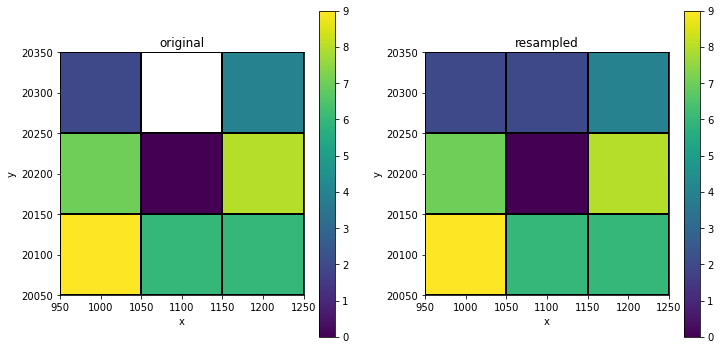

In [36]:
# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
struc2d_nan.plot(ax=axes[0], edgecolor='k')
axes[0].set_aspect('equal')
axes[0].set_title('original')
struc2d_nan_filled.plot(ax=axes[1], edgecolor='k')
axes[1].set_aspect('equal')
axes[1].set_title('resampled')

In [37]:
vertex1_nan_filled = resample.fillnan_dataarray_vertex_grid(vertex1_nan, xyi=xyi, cid=vertex1_nan.cid)

Text(0.5, 1.0, 'resampled')

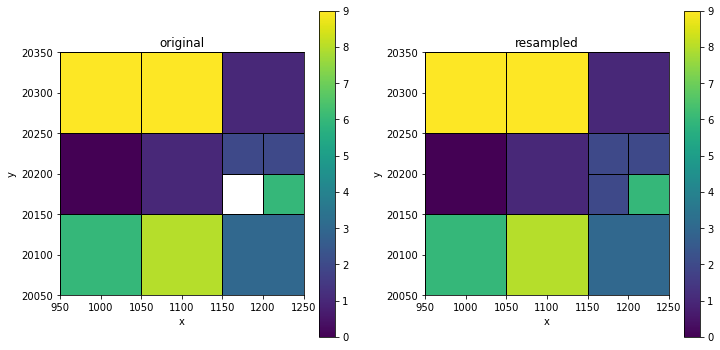

In [38]:
# plot results
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
nlmod.visualise.plots.plot_vertex_array(vertex1_nan, vertices, ax=axes[0], gridkwargs={'edgecolor': 'k'},
                                        vmin=vertex1_nan.min(), vmax=vertex1_nan.max());
axes[0].set_aspect('equal')
axes[0].set_title('original')
nlmod.visualise.plots.plot_vertex_array(vertex1_nan_filled, vertices, ax=axes[1], gridkwargs={'edgecolor': 'k'})
axes[1].set_title('resampled')